Немного полезных функций

Загрузка данных из файла. Тут две полезные конструкции. 
Первая, это построчное чтение реализованное с помощью
~~~
for line in open(path+'/movies.dat'):
~~~
Вторая -- функция split(), позволяющая разделить строку, по символу или последовательности символов в качестве разделителя.


In [6]:
#Чтение данных

def loadMovieLens1M(path='./ml-1m'):
# Получить названия фильмов
    movies={}
    for line in open(path+'/movies.dat'):
        (id,title)=line.split('::')[0:2] #при желании тут можно добавить чтение жанров.
        movies[id]=title
# Загрузить данные
    prefs={}
    for line in open(path+'/ratings.dat'):
        (user,movieid,rating,ts)=line.split('::')
        prefs.setdefault(user,{})
        prefs[user][movieid]=float(rating)
    return prefs, movies

In [7]:
%%time
critics, movies = loadMovieLens1M()


Wall time: 672 ms


In [8]:
recode_movie = {}
k = 0
for i in movies:
    recode_movie[i] = k
    k += 1
movie_num = k    

recode_users = {}
k = 0
for i in critics:
    recode_users[i] = k
    k += 1
user_num = k
    

Отберем, например, около 40 процентов пользователей:

In [9]:
%%time
from random import random, seed
from copy import deepcopy
seed(20)
critics_train = deepcopy(critics)
final_test = {}

# 40% пользователей
final_user_list = [u for u in critics if random()<0.40]

# для 40% пользователей спрячем 40% фильмов
for u in final_user_list:
    to_remove = [m for m in critics[u] if random()<0.40]
    final_test[u] = {}
    for m in to_remove:
        final_test[u][m] = critics[u][m]
        del critics_train[u][m]
    

Wall time: 855 ms


In [10]:
all_train_pairs = [(u, m, critics_train[u][m]) for u in critics_train for m in  critics_train[u]]
len(all_train_pairs)

842415

In [11]:
validate_pairs = [x for x in all_train_pairs if random()<0.15]
vset = set(validate_pairs)
train_pairs = [x for x in all_train_pairs if not x in vset]

In [12]:
user_list = [x for x in critics]
movie_list = [x for x in movies]

попробуем простейший вариант стохастического градиентного спуска

In [14]:
seed(6660)
L = 2
Pi = {}
Bi = {}
for u in user_list:
    Bi[u] = 0
    Pi[u] = []
    for i in range(L):
        Pi[u].append(random())
Ba = {}
Qa = {}        
for m in movie_list:
    Ba[m] = 0 
    Qa[m] = []
    for i in range(L):
        Qa[m].append(random())


In [15]:
len(train_pairs)

715521

In [16]:
from math import sqrt 
def evaluate_ratings(rating_list, Pi, Qa, Bi, Ba, L = 5):
    summ = 0
    for (u, m, r) in rating_list:
        rate = Bi[u] + Ba[m]
        for i in range(L):
            rate += Pi[u][i]*Qa[m][i]
        summ += (r - rate)*(r - rate)
    return sqrt(summ/len(rating_list))
        

In [17]:
%%time
train_error = [evaluate_ratings(train_pairs, Pi, Qa, Bi, Ba, L)]
print(train_error[-1])

3.2959759202100947
Wall time: 375 ms


In [18]:
%%time
validate_error = [evaluate_ratings(validate_pairs, Pi, Qa, Bi, Ba, L)]
print(validate_error[-1])

3.2927335103374493
Wall time: 110 ms


In [19]:
from random import sample, shuffle

gamma = 0.01

In [21]:
import numpy as np

In [22]:
%%time
evaluate_every = 5
for jjj in range(50):
    np.random.shuffle(train_pairs)
    for (u, m, r) in train_pairs:
    #one step of gradient
        rate = Bi[u] + Ba[m]
        for i in range(L):
            rate += Pi[u][i]*Qa[m][i]
        error = rate - r
        deltaBi = gamma*error     
        deltaBa = gamma*error     
        Bi[u] -= deltaBi
        Ba[m] -= deltaBi
        for i in range(L):
            deltaPi = (gamma*error*Qa[m][i])
            deltaQa = (gamma*error*Pi[u][i])
            Pi[u][i] -= deltaPi
            Qa[m][i] -= deltaQa
    if (jjj + 1) % evaluate_every == 0:
        train_error.append(evaluate_ratings(train_pairs, Pi, Qa, Bi, Ba, L))            
        validate_error.append(evaluate_ratings(validate_pairs, Pi, Qa, Bi, Ba, L))            
        print(jjj, train_error[-1], validate_error[-1])

4 0.8988369566989682 0.9159812248431186
9 0.8754975028953688 0.8981407450341489
14 0.8639842082439849 0.8898163354889277
19 0.85752490454475 0.8858529550876653
24 0.8537975714491632 0.8843341657234969
29 0.8502767277844652 0.8831761091587874
34 0.8483714618344679 0.8821599794399726
39 0.8470783525543343 0.8818172699472053
44 0.8455965448582637 0.8815670203359205
49 0.8443483906146751 0.8803150958319756
Wall time: 2min 10s


In [23]:
import seaborn as sns

<AxesSubplot:>

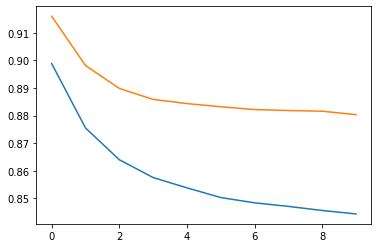

In [24]:
sns.lineplot(x = [x for x in range(len(train_error)-1)], y=train_error[1:])
sns.lineplot(x = [x for x in range(len(train_error)-1)], y=validate_error[1:])


In [ ]:
from scipy.sparse import csr_matrix

sub_len = len(train_pairs)#1000
data = np.ones(len(train_pairs[:sub_len])*2)
x_col = []
x_row = []

for i,(u,m,r) in enumerate(train_pairs[:sub_len]):
    x_row.append(i)    
    x_col.append(recode_users[u])    
    x_row.append(i)    
    x_col.append(recode_movie[m] + user_num)
X_train = csr_matrix((data,(x_row, x_col)), shape=(sub_len, user_num+movie_num))    
y_train = np.asarray([r for (u,m,r) in train_pairs[:sub_len]])


$$y=w_0 + \sum_{i=1}^{n}w_ix_i+\sum_{i=1}^{n}\sum_{j=i+1}^{n}\langle v_i,v_j\rangle x_ix_j$$

$$\frac{1}{2} \sum_{l=1}^k \big ((\sum_{i=1}^d v_{i, l} x_i)^2 - \sum_{i=1}^d v_{i, l}^2 x_i^2)$$

In [ ]:
import torch
import torch.nn as nn

class FM(nn.Module):
    def __init__(self, features_num=None, k=2):
        super().__init__()
        self.V = nn.Parameter(torch.randn(features_num, k), requires_grad=True)
        torch.nn.init.xavier_uniform_(self.V.data)
        self.linear = nn.Linear(features_num, 1)

    def forward(self, X):
        out_1 = ((X @ self.V) ** 2).sum(1, keepdim=True)
        out_2 = ((X ** 2) @ (self.V ** 2)).sum(1, keepdim=True)

        out_interaction = (out_1 - out_2) / 2
        out_linear = self.linear(X)
        return out_interaction + out_linear

In [ ]:
%%time
from torch import optim
from sklearn.metrics import mean_squared_error

# X_train_tensor, y_train_tensor = torch.from_numpy(X_train.toarray()), torch.from_numpy(y_train.reshape(-1, 1))
X_train_tensor = torch.sparse_coo_tensor([x_row, x_col], data, (sub_len, user_num+movie_num))

y_train_tensor = torch.from_numpy(y_train.reshape(-1, 1))

model = FM(X_train.shape[1])
criterion = nn.MSELoss() 
optimizer = optim.SGD(model.parameters(), lr=0.1)

for epoch in range(10):
    optimizer.zero_grad()
    predictions = model(X_train_tensor.float())
    loss = criterion(predictions, y_train_tensor.float())
    # get gradients
    loss.backward()
    # update parameters
    optimizer.step()
    
#X_test_tensor = torch.from_numpy(X_train.toarray())
predictions = model(X_train_tensor.float())
sqrt(mean_squared_error(y_train, predictions.squeeze().detach().numpy()))